🧪 Optimizing RTK:   0%|          | 0/600 [00:00<?, ?it/s]


🎯 Early stopping triggered! NSE ≥ 0.95

🕒 Optimization completed in 99 min 56 sec

✅ Best NSE = 0.9518 → File: opt_92.inp


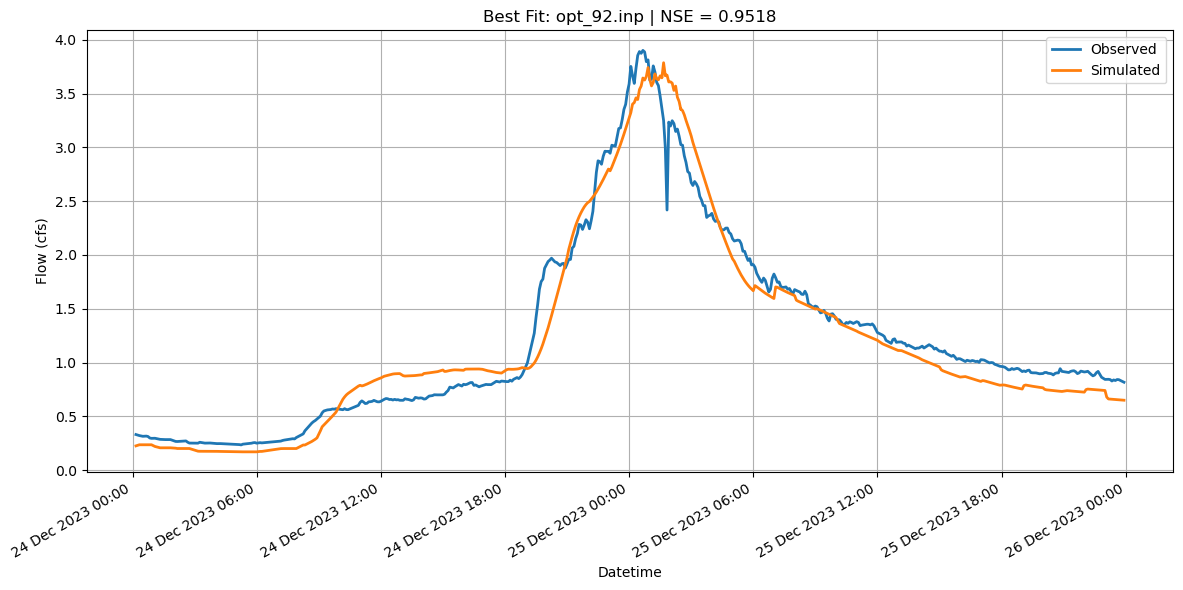


📋 RTK Matrix of Best Fit:

| Response   |      R |      T |      K |
|------------|--------|--------|--------|
| Short      | 0.0232 | 2.0000 | 1.9377 |
| Medium     | 0.0150 | 5.0000 | 3.0000 |
| Long       | 0.0204 | 8.2580 | 5.2537 |

📊 Flow Statistics Comparison:

+--------------------+------------+-------------+----------------+
| Metric             | Observed   | Simulated   | % Difference   |
+====================+============+=============+================+
| Total Volume (ft³) | 189,050.58 | 184,756.08  | -2.27%         |
+--------------------+------------+-------------+----------------+
| Peak Flow (cfs)    | 3.90       | 3.79        | -2.94%         |
+--------------------+------------+-------------+----------------+


In [ ]:
# === 📦 Imports ===
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from pyswmm import Simulation, Links
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm.notebook import tqdm
from tabulate import tabulate
import re
import os
import time

# === 📁 Paths ===
BASE_INP_PATH = Path("Base_INP_File/Example1.inp") #EPA-SWMM INP File
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
OUTPUT_FOLDER = Path(f"Optimized_INP_Files/{timestamp}")
OUTPUT_FOLDER.mkdir(exist_ok=True, parents=True)

# === ⚙️ Configurable Inputs ===
START_DATE = "12/24/2023" # ⬅️ Changeable
START_TIME = "00:00:00"   # ⬅️ Changeable
END_DATE = "12/26/2023"   # ⬅️ Changeable
END_TIME = "00:00:00"     # ⬅️ Changeable
ROUTING_STEP = "00:05:00" # ⬅️ Changeable
CALIBRATION_LINK_ID = "WDS-103_WDS-290" # Link ID to calibrate (can be changed based on the choice of Calibration Location)

# === 🔁 Update Simulation Times ===
def update_simulation_times(inp_path, start_date, start_time, end_date, end_time, routing_step):
    with open(inp_path, 'r') as f:
        lines = f.readlines()
    updated_lines = []
    for line in lines:
        if line.strip().startswith("START_DATE"):
            updated_lines.append(f"START_DATE       {start_date}\n")
        elif line.strip().startswith("START_TIME"):
            updated_lines.append(f"START_TIME       {start_time}\n")
        elif line.strip().startswith("END_DATE"):
            updated_lines.append(f"END_DATE         {end_date}\n")
        elif line.strip().startswith("END_TIME"):
            updated_lines.append(f"END_TIME         {end_time}\n")
        elif line.strip().startswith("ROUTING_STEP"):
            updated_lines.append(f"ROUTING_STEP     {routing_step}\n")
        else:
            updated_lines.append(line)
    with open(inp_path, 'w') as f:
        f.writelines(updated_lines)

update_simulation_times(BASE_INP_PATH, START_DATE, START_TIME, END_DATE, END_TIME, ROUTING_STEP)

# === 📥 Parse Observed Flow ===
def parse_timeseries(inp_path):
    timeseries_data = {}
    in_timeseries = False
    with open(inp_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('['):
                if in_timeseries:
                    break
                if line.upper() == '[TIMESERIES]':
                    in_timeseries = True
                    continue
            if in_timeseries:
                if not line or line.startswith(';'):
                    continue
                parts = line.split()
                if len(parts) >= 4:
                    label = parts[0]
                    timestamp = " ".join(parts[1:3])
                    value = float(parts[3])
                    if label not in timeseries_data:
                        timeseries_data[label] = []
                    timeseries_data[label].append((timestamp, value))
    df = pd.DataFrame(timeseries_data.get("Flow(cfs)", []), columns=["datetime", "Observed Flow"])
    df["datetime"] = pd.to_datetime(df["datetime"])
    return df.set_index("datetime").sort_index()

obs_df = parse_timeseries(BASE_INP_PATH)

# === 📈 NSE ===
def nse(sim, obs):
    sim = np.array(sim)
    obs = np.array(obs)
    return 1 - np.sum((sim - obs) ** 2) / np.sum((obs - np.mean(obs)) ** 2)

# === 🧰 INP RTK Updater ===
def update_inp_file(base_path, new_path, R_vals, T_vals, K_vals, hydrograph_id):
    with open(base_path, 'r') as f:
        lines = f.readlines()
    new_lines = []
    in_hydro = False
    row_idx = 0
    for line in lines:
        if line.strip().startswith('[HYDROGRAPHS]'):
            in_hydro = True
            new_lines.append(line)
            continue
        if in_hydro:
            if line.strip().startswith('['):
                in_hydro = False
                new_lines.append(line)
                continue
            if line.strip() and not line.strip().startswith(';') and hydrograph_id in line:
                parts = line.split()
                if len(parts) >= 6 and row_idx < 3:
                    parts[3] = f"{R_vals[row_idx]:.4f}"
                    parts[4] = f"{T_vals[row_idx]:.4f}"
                    parts[5] = f"{K_vals[row_idx]:.4f}"
                    line = ' '.join(parts) + '\n'
                    row_idx += 1
        new_lines.append(line)
    with open(new_path, 'w') as f:
        f.writelines(new_lines)

# === 🔬 Search Space with R_total and Alphas ===
space = [
    Real(0.01, 0.9, name="R_total"),
    Real(0.0, 1.0, name="alpha1"),
    Real(0.0, 1.0, name="alpha2"),
    Real(0.5, 2.0, name="T1"),
    Real(3.0, 5.0, name="T2"),
    Real(5.0, 10.0, name="T3"),
    Real(1.0, 2.0, name="K1"),
    Real(2.0, 3.0, name="K2"),
    Real(3.0, 7.0, name="K3")
]

results = []
MAX_CALLS = 600
INITIAL_POINTS = 35
TARGET_NSE = 0.95
progress_bar = tqdm(total=MAX_CALLS, desc="🧪 Optimizing RTK", leave=False)

@use_named_args(space)
def objective(**params):
    progress_bar.update(1)
    R_total = params["R_total"]
    alpha1 = params["alpha1"]
    alpha2 = params["alpha2"]
    T1, T2, T3 = params["T1"], params["T2"], params["T3"]
    K1, K2, K3 = params["K1"], params["K2"], params["K3"]

    if alpha1 + alpha2 > 1 or not (T1 < T2 < T3) or not (K1 < K2 < K3):
        return 1.0

    R1 = alpha1 * R_total
    R2 = alpha2 * R_total
    R3 = (1 - alpha1 - alpha2) * R_total

    sim_id = len(results)
    new_inp = OUTPUT_FOLDER / f"opt_{sim_id}.inp"
    update_inp_file(BASE_INP_PATH, new_inp, [R1, R2, R3], [T1, T2, T3], [K1, K2, K3], CALIBRATION_LINK_ID)

    try:
        with Simulation(str(new_inp)) as sim:
            times, flows = [], []
            for step in sim:
                flows.append(Links(sim)[CALIBRATION_LINK_ID].flow)
                times.append(sim.current_time)

        sim_series = pd.Series(flows, index=pd.to_datetime(times))
        merged = obs_df.join(sim_series.rename("Simulated Flow"), how="inner")
        if merged.empty:
            return 1.0
        score = nse(merged["Simulated Flow"], merged["Observed Flow"])
        results.append((score, new_inp, merged))

        if score >= TARGET_NSE:
            raise StopIteration(score)

        return 1 - score

    except StopIteration as stop:
        print(f"\n🎯 Early stopping triggered! NSE ≥ {TARGET_NSE}")
        raise stop
    except Exception as e:
        print(f"⚠️ Simulation failed for {new_inp.name}: {e}")
        return 1.0

# === 🚀 Run Optimization ===
start_time = time.time()
try:
    search = gp_minimize(
        func=objective,
        dimensions=space,
        acq_func="EI",
        n_calls=MAX_CALLS,
        n_initial_points=INITIAL_POINTS,
        random_state=42
    )
except StopIteration:
    pass
finally:
    progress_bar.close()
    elapsed = time.time() - start_time
    mins, secs = divmod(elapsed, 60)
    print(f"\n🕒 Optimization completed in {int(mins)} min {int(secs)} sec")

# === ✅ Best Result ===
best_score = max(results, key=lambda x: x[0])[0]
best_idx = [i for i, r in enumerate(results) if r[0] == best_score][0]
best_file, best_data = results[best_idx][1], results[best_idx][2]
print(f"\n✅ Best NSE = {best_score:.4f} → File: {best_file.name}")

# === 📈 Plot Best Fit with Full Datetime ===
plt.figure(figsize=(12, 6))
plt.plot(best_data.index, best_data['Observed Flow'], label='Observed', lw=2)
plt.plot(best_data.index, best_data['Simulated Flow'], label='Simulated', lw=2)
plt.title(f"Best Fit: {best_file.name} | NSE = {best_score:.4f}")
plt.xlabel("Datetime")
plt.ylabel("Flow (cfs)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y %H:%M'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# === 📋 RTK Extractor ===
def extract_rtk_from_inp(inp_file):
    with open(inp_file, 'r') as f:
        content = f.read()
    hydro_section = re.findall(r"\[HYDROGRAPHS\](.*?)\n\s*\[", content, re.DOTALL)
    if not hydro_section:
        return None
    lines = hydro_section[0].strip().split('\n')
    response_labels = ["Short", "Medium", "Long"]
    rtk_matrix = []
    label_idx = 0
    for line in lines:
        if line.startswith(';') or not line.strip():
            continue
        parts = re.split(r'\s+', line.strip())
        if len(parts) >= 6:
            response_type = response_labels[label_idx] if label_idx < len(response_labels) else f"Response_{label_idx+1}"
            R, T, K = parts[3:6]
            rtk_matrix.append((response_type, R, T, K))
            label_idx += 1
    df = pd.DataFrame(rtk_matrix, columns=["Response", "R", "T", "K"])
    return df.set_index("Response")

rtk_df = extract_rtk_from_inp(best_file)
if rtk_df is not None:
    rtk_df = rtk_df.astype(float)
    print("\n📋 RTK Matrix of Best Fit:\n")
    print(tabulate(
        rtk_df.reset_index().values,
        headers=["Response", "R", "T", "K"],
        tablefmt="github",
        floatfmt=".4f"
    ))

# === 📊 Volume and Peak Flow Summary ===
total_obs = best_data['Observed Flow'].sum() * 60 * 5
total_sim = best_data['Simulated Flow'].sum() * 60 * 5
peak_obs = best_data['Observed Flow'].max()
peak_sim = best_data['Simulated Flow'].max()
vol_diff_pct = 100 * (total_sim - total_obs) / total_obs
peak_diff_pct = 100 * (peak_sim - peak_obs) / peak_obs

summary_table = [
    ["Total Volume (ft³)", f"{total_obs:,.2f}", f"{total_sim:,.2f}", f"{vol_diff_pct:+.2f}%"],
    ["Peak Flow (cfs)", f"{peak_obs:,.2f}", f"{peak_sim:,.2f}", f"{peak_diff_pct:+.2f}%"]
]

print("\n📊 Flow Statistics Comparison:\n")
print(tabulate(summary_table, headers=["Metric", "Observed", "Simulated", "% Difference"], tablefmt="grid"))
      